# Transfer learning using Pytorch/Lightning

This project is a showcase how to perform transfer learning using pytorch and lightning on a image classification task. The goal of the project is to classify different images of musical instruments. Dataset was downloaded from Kaggle and the link is provided here: https://www.kaggle.com/datasets/gpiosenka/musical-instruments-image-classification

`Conda` was used to create a virtual environment with all necessary dependencies which will be used for this project. `Python` version is `3.11.7`. All necessary dependencies with specified versions are in the `./requirements.txt` file in the project main directory.

Model was trained on a macbook pro 2021 M1 chip laptop and later tested on an HP probook g5 which runs on Ubutnu 22.04.

In [1]:
# Dependencies

import numpy as np
from PIL import Image
from IPython.display import SVG

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 10
plt.style.use('ggplot')

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, utils, datasets
from torchvision.models import resnet18
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision.models as models

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger

In [17]:
DATA_PATH = "./data"
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

In [18]:
# Define transformations and augmentations of data,

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((226, 226)),
        transforms.CenterCrop((224, 224)),
        transforms.ColorJitter(),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    "val": transforms.Compose([
        transforms.Resize((226, 226)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ]),
    "test": transforms.Compose([
        transforms.Resize((226, 226)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])
}

We can see that we apply augmentation to the training data but not to the validation and testing data. The main goal of the augmentation is to get the model to generalize better on the data it has not seen before so there are 3 augmentation techinques we applied to the data:</br>
`transforms.ColorJitter()` - Randomly change the brightness, contrast, saturation and hue of an image</br>
`transforms.RandomRotation(degrees=45)` - Randomly rotates od a 45 degree angle</br>
`transforms.RandomHorizontalFlip()` - Randomly flip the image on horizontal axis</br>
We perform the same transformation on all three data sets on where we resize the image, crop it to the correct dimensions `(224, 224)` make them a tensor and finally normalize them. The normalization is used to make training faster and more stable.

In [20]:
# Fetching train data
train_data = datasets.ImageFolder(root = DATA_PATH + "/train",
                                  transform = image_transforms["train"])
# Validation data
val_data = datasets.ImageFolder(root = DATA_PATH + "/val",
                                transform = image_transforms["val"])
# Test data
test_data = datasets.ImageFolder(root = DATA_PATH + "/test",
                                 transform = image_transforms["test"])

# Creating data loades
train_loader = DataLoader(dataset=train_data, shuffle=True, batch_size=32)
val_loader = DataLoader(dataset=val_data, shuffle=False, batch_size=32)
test_loader = DataLoader(dataset=test_data, shuffle=False, batch_size=32)

`datasets.ImageFolder` is used to specify where the images are and we also specify which transformation will be done on which dataset.

`DataLoader` class allows us to train the data in batches and we specify the batch_size as 32. This means 32 images will be in a batch and will go through a forward and a backward pass.

In [21]:
# Getting the name of the instrument and the index

train_data.class_to_idx

{'Didgeridoo': 0,
 'Tambourine': 1,
 'Xylophone': 2,
 'acordian': 3,
 'alphorn': 4,
 'bagpipes': 5,
 'banjo': 6,
 'bongo drum': 7,
 'casaba': 8,
 'castanets': 9,
 'clarinet': 10,
 'clavichord': 11,
 'concertina': 12,
 'drums': 13,
 'dulcimer': 14,
 'flute': 15,
 'guiro': 16,
 'guitar': 17,
 'harmonica': 18,
 'harp': 19,
 'marakas': 20,
 'ocarina': 21,
 'piano': 22,
 'saxaphone': 23,
 'sitar': 24,
 'steel drum': 25,
 'trombone': 26,
 'trumpet': 27,
 'tuba': 28,
 'violin': 29}

We have 30 different classes of instruments.

In [22]:
idx_to_class = {v: k for k, v in train_data.class_to_idx.items()}
idx_to_class

{0: 'Didgeridoo',
 1: 'Tambourine',
 2: 'Xylophone',
 3: 'acordian',
 4: 'alphorn',
 5: 'bagpipes',
 6: 'banjo',
 7: 'bongo drum',
 8: 'casaba',
 9: 'castanets',
 10: 'clarinet',
 11: 'clavichord',
 12: 'concertina',
 13: 'drums',
 14: 'dulcimer',
 15: 'flute',
 16: 'guiro',
 17: 'guitar',
 18: 'harmonica',
 19: 'harp',
 20: 'marakas',
 21: 'ocarina',
 22: 'piano',
 23: 'saxaphone',
 24: 'sitar',
 25: 'steel drum',
 26: 'trombone',
 27: 'trumpet',
 28: 'tuba',
 29: 'violin'}

`id_to_class` dictionary will later be used to get the name of the instrument class from index predictions of the model.

In [23]:
# Helper function for EDA
def get_class_distribution_loaders(dataloader_obj, dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    if dataloader_obj.batch_size == 1:
        for _,label_id in dataloader_obj:
            y_idx = label_id.item()
            y_lbl = idx_to_class[y_idx]
            count_dict[str(y_lbl)] += 1
    else:
        for _,label_id in dataloader_obj:
            for idx in label_id:
                y_idx = idx.item()
                y_lbl = idx_to_class[y_idx]
                count_dict[str(y_lbl)] += 1
    return count_dict

This function will allow us to se the count of instruments in each indidvidual class.

In [8]:
get_class_distribution_loaders(train_loader, train_data)

{'Didgeridoo': 145,
 'Tambourine': 275,
 'Xylophone': 205,
 'acordian': 209,
 'alphorn': 134,
 'bagpipes': 137,
 'banjo': 155,
 'bongo drum': 141,
 'casaba': 218,
 'castanets': 130,
 'clarinet': 133,
 'clavichord': 207,
 'concertina': 152,
 'drums': 184,
 'dulcimer': 126,
 'flute': 194,
 'guiro': 117,
 'guitar': 137,
 'harmonica': 142,
 'harp': 173,
 'marakas': 114,
 'ocarina': 127,
 'piano': 119,
 'saxaphone': 127,
 'sitar': 216,
 'steel drum': 128,
 'trombone': 163,
 'trumpet': 167,
 'tuba': 175,
 'violin': 143}

Classes are not completely balanced but there should be enough of instruments in each class which will be sufficient to train a fairly robust model.

In [9]:
get_class_distribution_loaders(val_loader, val_data)

{'Didgeridoo': 5,
 'Tambourine': 5,
 'Xylophone': 5,
 'acordian': 5,
 'alphorn': 5,
 'bagpipes': 5,
 'banjo': 5,
 'bongo drum': 5,
 'casaba': 5,
 'castanets': 5,
 'clarinet': 5,
 'clavichord': 5,
 'concertina': 5,
 'drums': 5,
 'dulcimer': 5,
 'flute': 5,
 'guiro': 5,
 'guitar': 5,
 'harmonica': 5,
 'harp': 5,
 'marakas': 5,
 'ocarina': 5,
 'piano': 5,
 'saxaphone': 5,
 'sitar': 5,
 'steel drum': 5,
 'trombone': 5,
 'trumpet': 5,
 'tuba': 5,
 'violin': 5}

In [10]:
# Procedure to get a single batch

single_batch = next(iter(train_loader))

In [11]:
print(single_batch)

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, 

In [12]:
# Selecting the first image tensor from the batch.
single_image = single_batch[0][0]
single_image.shape

torch.Size([3, 224, 224])

A single image is of the correct shape. 3 is the number of channels (RGB) and 224, 224 represent the width and the height and the width of the image.

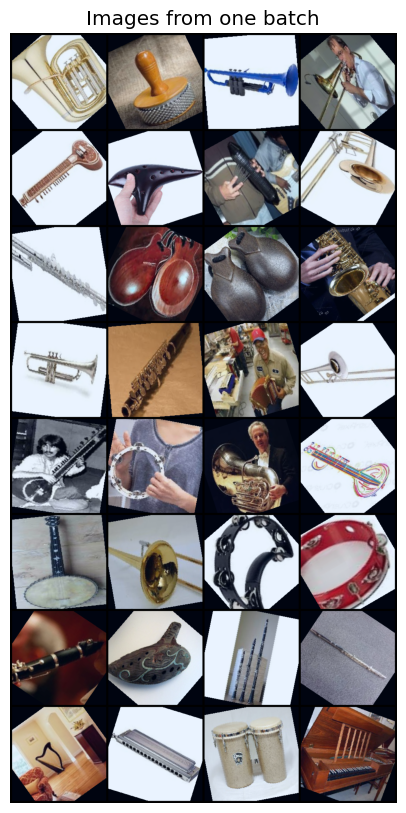

In [13]:
# Get a single batch of data from the DataLoader

images, labels = next(iter(train_loader))

grid = utils.make_grid(images, nrow=4, padding=5, normalize=True)

# Plot the grid of images
plt.imshow(grid.permute(1, 2, 0)) #prepare tensor for visualization - height, width, channels
plt.axis('off')
plt.title('Images from one batch')
plt.show()


We can see the instruments are in various contexts, some of the instruments are in a plain white backgroud, and others are played by the player. This is good  because the model will generalize better and hopefully not have some kind of bias.

## Transfer learning class

In the next cell the `TransferLearningModel` class is defined. It inherits from the `LightningModule` class which will make the training much easier. 

Most important methods of this class are:</br>
- forward
- training_step
- validation_step
- configure_optimizers

This methods must be implemented for the model to be trained correctly.
This class is fairly complex so let's break it down.

The backbone of the class is a `resnet18` model which means we will take a model which was pretrained on the imagenet dataset and apply transfer learning techniques for it to fit our problem. We will remove the final layer of the resnet and use everything as a feature extractor for our model. The final layer will be a fully connected layer with the filters as the input and the number of different instrument classes as the output.

Only this final layer will be trained in this case.

Loss funcition is `cross_entropy` which is the preffered loss when working with multiclass classification problems.</br>
`Adam` is the optimizer.

There are two more methods implemented:
- `predict` - which is used to predict on a single image
- `predict_on_test_loader` - which is used to get prediction and correct classes from the `test_loader`

In [24]:
# Creating the class

class TransferLearningModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        backbone = models.resnet18(weights="DEFAULT")
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)

        num_target_classes = 30
        self.classifier = nn.Linear(num_filters, num_target_classes)

        self.train_loader = None
        self.val_loader = None
    
    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters())
        return optimizer
    
    def predict(self, image_path):
        self.eval()
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=MEAN, std=STD) 
        ])        
        image = Image.open(image_path).convert('RGB') 
        image_tensor = transform(image).unsqueeze(0)
        
        with torch.no_grad():
            outputs = self(image_tensor)
            _, predicted = torch.max(outputs, 1)
            predicted_class = predicted.item()
        
        return predicted_class
    
    def predict_on_test_loader(self, test_loader):
        self.eval()
        predicted_labels = []
        true_labels = []
        
        with torch.no_grad():
            for x, y in test_loader:
                outputs = self(x)
                _, predicted = torch.max(outputs, 1)
                predicted_labels.extend(predicted.cpu().numpy())
                true_labels.extend(y.cpu().numpy())
        
        return predicted_labels, true_labels

In [25]:
# Creating the model object

model = TransferLearningModel()
model.train_loader = train_loader
model.val_loader = val_loader

# Creating the trainer object

trainer = L.Trainer(max_epochs=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


We must create 2 different objects. One in the `model` object which will create an instance of the `TransferLearningModel` class and second is the `trainer` object from the `L.Trainer` class which will allow us to make the training much easier. The model will train for 50 epochs and after that a decision will be made if it is necessary to train more.

In [16]:
# Training the model

trainer.fit(model)

Missing logger folder: /Users/damir_bogdan/Documents/Projects/music_instruments/lightning_logs

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 11.2 M
1 | classifier        | Linear     | 15.4 K
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.768    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/damir_bogdan/miniconda3/envs/lightning_vision_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/damir_bogdan/miniconda3/envs/lightning_vision_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 49: 100%|██████████| 150/150 [00:09<00:00, 15.23it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 150/150 [00:09<00:00, 15.13it/s, v_num=0]


Trainer automatically logged all the information that is specified in the TransferLearningModel class. train and validation loss were of importance so they were saved and can be accessed from `tensorboard`. To access tensorboard must be activated from the terminal with the command: `tensoboard --logdir=lightning_logs`. </br>

After inspection the .svg files of losses were downloaded and will be displayed here.

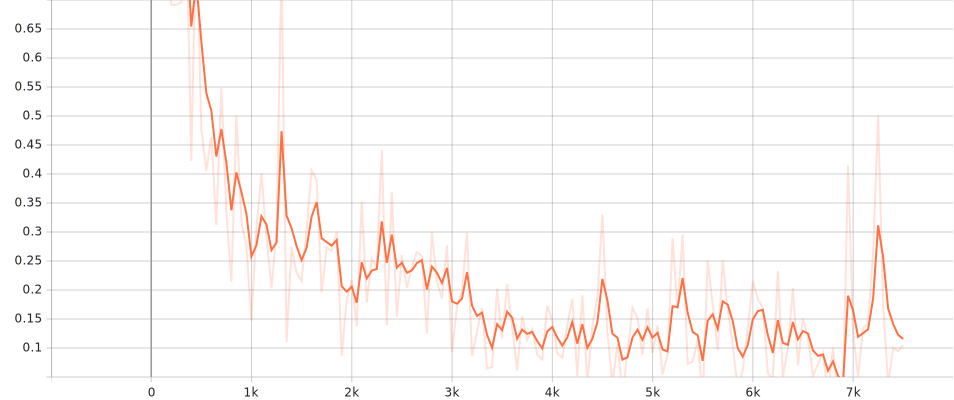

In [12]:
# Training loss
SVG(filename="train_loss.svg")

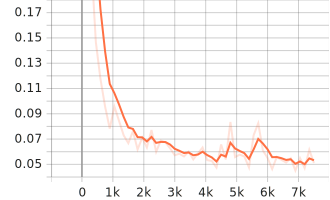

In [14]:
# Validation loss
SVG(filename="val_loss.svg")

This concludes the training of the model. Now let's check the accuracy of the model on the test set.

In [31]:
# Calculate accuracy on the test set

predicted_labels, true_labels = model.predict_on_test_loader(test_loader)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.00%


Accuracy on the test set is quite large. We could say that the model is ready to be used, no more training is needed.

In [37]:
# Saving the model

trainer.save_checkpoint("50epochs.ckpt")

The `.save_checkpoint()` method saves the weights and characteristics of the model and allows the model to be loaded later on for inference.

In [26]:
# Loading the model

loaded_model = TransferLearningModel.load_from_checkpoint("50epochs.ckpt")

After loading the model I will inspect if the model correctly predicts two of my personal guitars as guitars.

In [27]:
loaded_model.predict("./my_harley.jpeg")

17

Model returns the index of the class.

In [28]:
print(idx_to_class[loaded_model.predict("./my_harley.jpeg")])

guitar


After converting the index to the name of the class intruments it correctly predicts my first guitar as guitar.

In [29]:
loaded_model.predict("./my_schecter.jpeg")

17

In [30]:
print(idx_to_class[loaded_model.predict("./my_schecter.jpeg")])

guitar


The second guitar is also correctly classified.

This concludes my project which used transfer learning on a resnet18 architecture to classify different instruments.